# Photosynthestic measurement statistical testing

We want to perform a statistical test to see if the phi2 and NPQ curves for the various conditions are significantly different from one another. To do this, we'll use pandas to implement [this spreadhseet method](https://pmc.ncbi.nlm.nih.gov/articles/PMC10617697/) for determining whether two arbitrary curves are significantly different.

In [1]:
import pandas as pd
import numpy as np

## Read in and format data
The paper method expects data of this format:

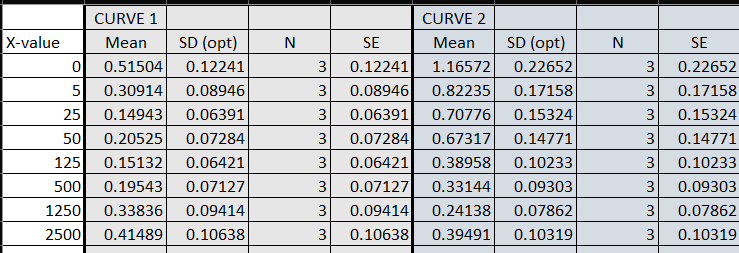

In [2]:
curves = pd.read_csv('../data/7h_acclimation.csv')
curves.head()

,Oxygen,Time,NPQ,Phi2
0,2,0.0000,0.4951,0.1662
1,2,0.0342,0.8324,0.2652
2,2,0.0667,0.9611,0.2952
3,2,0.1000,1.0663,0.3038
4,2,0.1333,1.1211,0.3128


Check how many samples we have for each time point at each condition:

In [14]:
check_cols = curves.groupby(by=['Oxygen', 'Time']).count().to_numpy()
print(f'Do we have the same number of samples across all timepoints and conditions? {(check_cols[0] == check_cols).all(0)}')
print(f'There are {check_cols[0][0]} samples for phi2 and {check_cols[0][1]} samples for NPQ at each condition.')
N = check_cols[0][0]

Do we have the same number of samples across all timepoints and conditions? [ True  True]
There are 4 samples for phi2 and 4 samples for NPQ at each condition.


In [ ]:
curves_with_stats = curves.groupby(by=[''])